## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [65]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [66]:
# Reading the data and viewing the first few rows
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [67]:
# No. of rows in the dataset
df.shape[0]

294478

c. The number of unique users in the dataset.

In [68]:
# No. of unique users
df.user_id.nunique()

290584

d. The proportion of users converted.

In [69]:
# No. of users that have converted
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [70]:
# total no. of group & page mismatching
group_error = len(df.query("group == 'treatment' & landing_page != 'new_page'"))
treatment_error = len(df.query("landing_page == 'new_page' & group != 'treatment'"))
total = group_error + treatment_error
total

3893

f. Do any of the rows have missing values?

In [71]:
# No. of NaNs
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [72]:
# creating new df without the mismatching rows
df2 = df[(df.group == 'treatment') & (df.landing_page == 'new_page')]
df2 = df2.append(df[(df.group == 'control') & (df.landing_page == 'old_page')])

In [73]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [74]:
# no. of unique users
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [75]:
# find the duplicated users
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [76]:
# display the duplicated user
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [77]:
# dropping the duplicated user
df2.drop(1899, inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [78]:
# probability of all converted users
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [79]:
# probability of control group conversion
df2.query("group == 'control'")['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [80]:
# probability of treatment group conversion
df2.query("group == 'treatment'")['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [81]:
# probability of receiving the new page
df2.query("landing_page == 'new_page'").shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**No, becouse the 50% people received the new page and the conversion rate from both groups is almost the same.** 



<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**H0: 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 =< 0**

**Hl: 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 > 0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [82]:
# probability of new page conversion
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [83]:
# probability of old page conversion
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [84]:
# no. of users converted from treatment group
n_new = df2.query("group == 'treatment'")['converted'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [85]:
# no. of users converted from control group
n_old = df2.query("group == 'control'")['converted'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [86]:
# simulate n_new transactions with probability of conversion p_new
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1-p_new), p_new])
new_page_converted


array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [87]:
# simulate n_old transactions with probability of conversion p_old
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1-p_old), p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [88]:
# different between the two means
null_mean = new_page_converted.mean() - old_page_converted.mean()
null_mean

0.000472704174033306

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [89]:
# simulate 10,000 values of the diffrence betwwen proportions
new_converted_simulation = np.random.binomial(n_new, p_new, 10000) / n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000) / n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

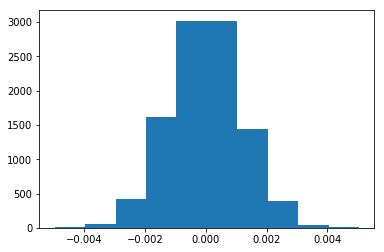

In [90]:
# plot sampling distribution
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [91]:
# calculate the observed diffrence in proportions
obs_diff = df2.query("group == 'treatment'")['converted'].mean() - df2.query("group == 'control'")['converted'].mean()

# probability of a statistic higher than observed
(p_diffs > obs_diff).mean()

0.90890000000000004

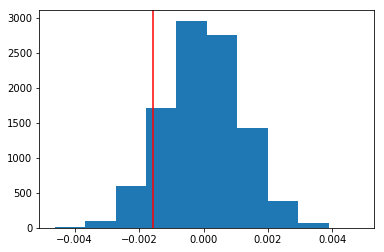

In [92]:
# simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), 10000)

# Plot observed statistic with the null distibution
plt.hist(null_vals)
plt.axvline(x=obs_diff, color='red');


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**(type I error = 0.05) <(p_value = 0.906) so we've significant evidence to accept the Null Hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [93]:
import statsmodels.api as sm
convert_old = df2.query("landing_page == 'old_page' & converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' & converted == 1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]
print(convert_old, convert_new, n_old, n_new)


17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [94]:
# test for proportions based on normal (z) test
z_stat, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_stat, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Yes, it confirms our decesion to accept the Null.**


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**the Logistic Regression, as we have only two possible outcomes.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [105]:
# create dummy variables
df2['intercept'] = 1
df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['ab_page'] = df2['new_page']

In [106]:
# drop unnessary columns
df2 = df2.drop(['old_page', 'new_page'], axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [107]:

# fit regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [108]:
# view regression summary
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 04 Apr 2021   Pseudo R-squ.:               8.077e-06
Time:                        12:57:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with( ab_page = 0.190 ) > (type I error rate = 0.05), so we have noststistical evidince that the landing_page has correlation with predicting the conversion rate.**

**The null and alternative hypotheses associated with the Regression model: H0: B1 = 0 Hl: B1 !=0**

**the null and alternative hypotheses associated with the A/B Test: H0: 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 =< 0 Hl: 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 > 0**

**The null and alternative hypotheses associated with the Regression model describe the predicted change in the response for every one unit increase in the explanatory variable, however in A/B test the null hypothesis is a hypothesis that believed to be true and The alternative hypothesis is what hoped that the A/B test will prove to be true.**

In [109]:
1 / np.exp(-0.0150)

1.0151130646157189

**If an individuals received the ab_page, they are 1.01511 times more likely to be converted.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**At this point, it does not seem that the landing_page has much impact on whether a user converts. So, it is probably a good idea to see whether other factors might predict the conversion rate. But, first we should make sure that those terms are not correlated with one another to avoid the Multi-collinearity issue.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [111]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [112]:
# view countries in the df 
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [113]:
### Create the necessary dummy variables
df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [114]:
# fit logistic regression model
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US']])
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 04 Apr 2021   Pseudo R-squ.:               1.521e-05
Time:                        13:06:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0099      0.013     -0.746      0.456      -0.036       0.016
US            -0.0507      0.028     -1.786      0.074      -0.106       0.005
==============================================================================
"""

**With observing the p-values associated with countries, we conclude that there isn't significant relationship between individuals' countries and conversion rate.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [115]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [116]:
### Fit Your Linear Model And Obtain the Results
# apply higher order term by fitting the interaction between ab_page & UK
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK', 'ab_page', 'UK_ab_page']])
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Sun, 04 Apr 2021   Pseudo R-squ.:               3.125e-05
Time:                        13:08:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1557
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0257      0.027    -75.518      0.000      -2.078      -1.973
CA             0.0407      0.027      1.515      0.130      -0.012       0.093
UK             0.0335      0.031      1.070      0.285      -0.028       0.095
ab_page       -0.0236      0.013     -1.785      0.074      -0.049       0.002
UK_ab_page     0.0344      0.026      1.306      0.192      -0.017       0.086
==============================================================================
"""

In [117]:
### Fit Your Linear Model And Obtain the Results
# apply higher order term by fitting the interaction between ab_page & CA
df_new['CA_ab_page'] = df_new['CA'] * df_new['ab_page']
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US', 'ab_page', 'CA_ab_page']])
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Sun, 04 Apr 2021   Pseudo R-squ.:               2.589e-05
Time:                        13:08:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2390
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9859      0.015   -128.638      0.000      -2.016      -1.956
CA            -0.0006      0.018     -0.031      0.975      -0.036       0.035
US            -0.0507      0.028     -1.786      0.074      -0.106       0.005
ab_page       -0.0018      0.021     -0.086      0.931      -0.043       0.039
CA_ab_page    -0.0188      0.025     -0.752      0.452      -0.068       0.030
==============================================================================
"""

In [118]:
### Fit Your Linear Model And Obtain the Results
# apply higher order term by fitting the interaction between ab_page & US
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US', 'ab_page', 'US_ab_page']])
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366111
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Sun, 04 Apr 2021   Pseudo R-squ.:               2.827e-05
Time:                        13:09:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1981
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9807      0.013   -154.711      0.000      -2.006      -1.956
CA            -0.0099      0.013     -0.744      0.457      -0.036       0.016
US            -0.0233      0.039     -0.603      0.546      -0.099       0.052
ab_page       -0.0123      0.012     -1.047      0.295      -0.035       0.011
US_ab_page    -0.0552      0.053     -1.035      0.301      -0.160       0.049
==============================================================================
"""

**Based on the result it seems there is no significant effect on conversion rate due to the country as our interaction's      p-value still > than 0.05**



# Conclusion


### Probability :

Based on that half of people received the new page and the conversion rate from both groups is almost the same, we conclude that there is no sufficient evidence to say that the new treatment page leads to more conversions.

### A/B Test:

By comparing statistics to the simulated diffrence in proportions, it was observed that: With a type 1 (0.05) error rate and p_value 0.906, so we've significant evidence to accept the Null Hypothesis.

### Regression approach:


After performing the Logistic regression we found that:

> There is no ststistical evidince that the landing_page has correlation with predicting the conversion rate.

> If an individuals received the new_page, they are 1.01511 times more likely to be converted than the old_page.

> By observing the p-values associated with countries, we conclude that there isn't significant relationship between individuals' countries and conversion rate even after applying the interactions.

In [119]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0